In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
import arima
import datetime
%matplotlib inline


d:\app\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
features = pd.read_csv('raw_data/features.csv')
features.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [90]:
features[np.logical_not(np.isnan(features.MarkDown3))].head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
92,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False
93,1,2011-11-18,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False
94,1,2011-11-25,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,True
95,1,2011-12-02,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False
96,1,2011-12-09,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False


In [3]:
stores = pd.read_csv('raw_data/stores.csv')
stores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train_data = pd.read_csv('raw_data/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


lookup store1 dept1's historical sales

In [5]:
dept_data=train_data[np.logical_and(train_data.Store==1,train_data.Dept == 1)]

dept_data=pd.DataFrame(dept_data[['Weekly_Sales','IsHoliday','Date']].values,
                       index=pd.DatetimeIndex(dept_data['Date']),columns=['Weekly_Sales','IsHoliday','Date'])
dept_train=dept_data.iloc[:105,]
dept_test=dept_data.iloc[105:,]
for df in (dept_data,dept_train,dept_test):
    df.Weekly_Sales = df.Weekly_Sales.astype('float64')
    df.IsHoliday = df.IsHoliday.astype('int64')
dept_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2010-02-05 to 2012-02-03
Data columns (total 3 columns):
Weekly_Sales    105 non-null float64
IsHoliday       105 non-null int64
Date            105 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ KB


d:\app\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


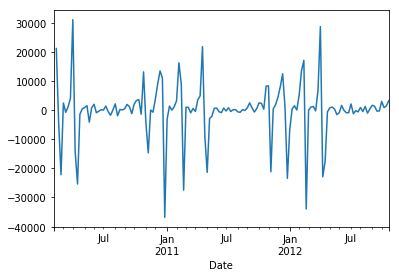

In [6]:
dept_data.Weekly_Sales.diff().plot()

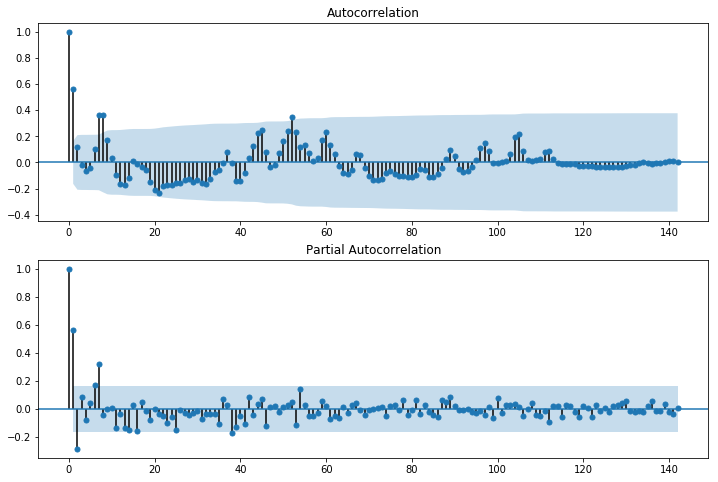

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dept_data.Weekly_Sales.dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dept_data.Weekly_Sales.dropna(), ax=ax2)

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(dept_data.Weekly_Sales)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.522164
p-value                          0.110174
#Lags Used                       6.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64

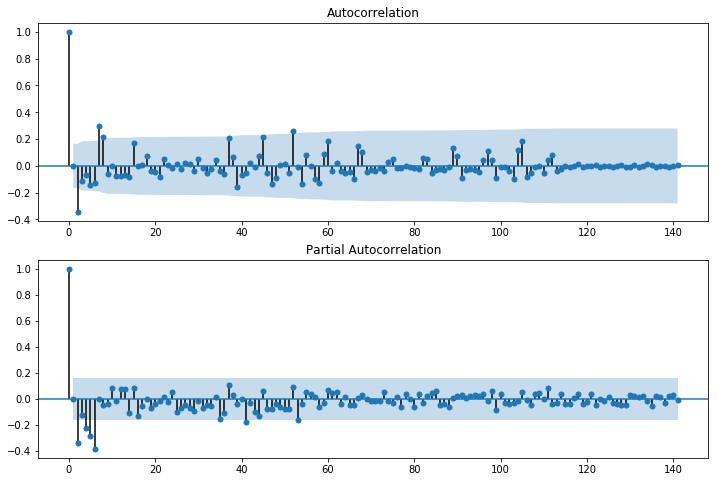

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dept_data.Weekly_Sales.diff().dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dept_data.Weekly_Sales.diff().dropna(), ax=ax2)

In [10]:
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(dept_data.Weekly_Sales.diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.104431e+01
p-value                        5.269934e-20
#Lags Used                     5.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64

In [11]:
def score(predict_data,validate_data):
    validate_data['Weight'] = np.array([5 if holiday else 1 for holiday in validate_data['IsHoliday']])
    return np.sum(np.abs((predict_data.Weekly_Sales-validate_data.Weekly_Sales)*validate_data.Weight)) / np.sum(validate_data.Weight)

d:\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3521.9556521739141

In [60]:
import statsmodels.api as sm
import traceback

def select_arima_model(sales, orders, season, factors=None,speedup=False):
    best_r = None
    best_o = None
    min_aic=9999999999999
    min_bic=9999999999999
        
    for o,s in zip(orders,season):
        try:
            if speedup:
                m=sm.tsa.statespace.SARIMAX(sales,order=o,seasonal_order=s,exog=factors,
                         simple_differencing=True, enforce_stationarity=False, enforce_invertibility=False)
                    
            else:
                m=sm.tsa.statespace.SARIMAX(sales,order=o,seasonal_order=s,exog=factors)
                
            r=m.fit(disp=False)
            if r.aic < min_aic and r.bic < min_bic:
                best_r = r
                best_o = o+s
                min_aic=r.aic
                min_bic=r.bic
                print(best_o,r.aic,r.bic)

        except Exception as e:
            print(e)
#             traceback.print_exc()
            
    return best_r,best_o

def make_orders(range_num, seq_num):
    if seq_num == 0:
        return [[]]
    else:
        orders=[]
        sub_orders=make_orders(range_num,seq_num-1)
        for o in sub_orders:
            for i in range(range_num):
                s=o.copy()
                s.append(i)
                orders.append(s)
        return orders


In [14]:
class ArimaModel():
    def __init__(self):
        pass
    
    def fit(self, train_data, orders, seasonal_orders, factors=None):
        train_resample=train_data.resample('1W').sum()
        train_resample.fillna(0)
        train_resample.index = train_resample.index-(train_resample.index[0]-train_data.index[0])
        if factors is None:
            self.m, self.o = select_arima_model(train_resample.Weekly_Sales,orders,seasonal_orders)
        else:
            self.m, self.o = select_arima_model(train_resample.Weekly_Sales,orders,seasonal_orders,train_resample[factors])

    def predict(self, test_data,factors=None):
        predict_data = test_data.copy()
        predict_data=predict_data.resample('1W').sum()
        predict_data.index = predict_data.index-(predict_data.index[0]-test_data.index[0])
        predict_data.fillna(0)
        predict_data['Weekly_Sales']=0
        
        if factors is None:
            predicts=self.m.forecast(len(test_data))
        else:
            predicts=self.m.forecast(len(test_data),exog=predict_data[factors])
        for date in predict_data.index:
            sale_data = predicts[predicts.index == date]
            if len(sale_data) == 1:
                predict_data.loc[date,'Weekly_Sales'] = sale_data[date]
        return predict_data
    
arima_m = ArimaModel()
orders=make_orders(3,3)
arma_orders=[(o[0],o[1],o[2]) for o in orders]
seasonal_orders=[(0,0,0,0) for o in orders]
arima_m.fit(dept_train,arma_orders,seasonal_orders)
dept_predict=arima_m.predict(dept_test)
arima_m.o, arima_m.m.aic, arima_m.m.bic, score(dept_predict,dept_test)

Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 17, in select_arima_model
    m=sm.tsa.statespace.SARIMAX(sales,order=o,seasonal_order=s,exog=factors)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 510, in __init__
    endog, exog=exog, k_states=k_states, k_posdef=k_posdef, **kwargs
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 97, in __init__
    self.initialize_statespace(**kwargs)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 130, in initialize_statespace
    self.ssm = KalmanSmoother(endog.shape[0], self.k_states, **kwargs)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_smoother.py", line 343, in __init__
    k_endog, k_states, k_posdef, results_class=results_class, **kwargs
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py", line 213, in __init__
    k_endo

Number of states in statespace model must be a positive number.
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
could not broadcast input array from shape (0,0) into shape (1,1)
(0, 1, 1, 0, 0, 0, 0) 2193.94989158 2199.25781228


d:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\app\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 17, in select_arima_model
    m=sm.tsa.statespace.SARIMAX(sales,order=o,seasonal_order=s,exog=factors)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 524, in __init__
    self.ssm.transition = self.initial_transition
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 795, in initial_transition
    transition[start:end, start:end] = companion_matrix(self._k_order)
ValueError: could not broadcast input array from shape (0,0) into shape (1,1)
Traceback (most recent call

(0, 1, 2, 0, 0, 0, 0) 2169.44439795 2177.406279
could not broadcast input array from shape (0,0) into shape (2,2)
non-invertible starting MA parameters found with `enforce_invertibility` set to True.


Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 19, in select_arima_model
    r=m.fit(disp=False)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 403, in fit
    start_params = self.start_params
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 1002, in start_params
    raise ValueError('non-invertible starting MA parameters found'
ValueError: non-invertible starting MA parameters found with `enforce_invertibility` set to True.


non-invertible starting MA parameters found with `enforce_invertibility` set to True.


Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 19, in select_arima_model
    r=m.fit(disp=False)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 403, in fit
    start_params = self.start_params
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 1002, in start_params
    raise ValueError('non-invertible starting MA parameters found'
ValueError: non-invertible starting MA parameters found with `enforce_invertibility` set to True.


Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(2, 1, 1, 0, 0, 0, 0) 2166.49796753 2177.11380893
non-invertible starting MA parameters found with `enforce_invertibility` set to True.


Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 19, in select_arima_model
    r=m.fit(disp=False)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 403, in fit
    start_params = self.start_params
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 990, in start_params
    raise ValueError('Non-stationary starting autoregressive'
ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 19, in select_arima_model
    r=m.fit(disp=False)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 403, in fit
    start_params = self.start_params
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 990, in start_params
    raise ValueError('Non-stationary starting autoregressive'
ValueErro

non-invertible starting MA parameters found with `enforce_invertibility` set to True.


Traceback (most recent call last):
  File "<ipython-input-13-584aa30c8d0d>", line 19, in select_arima_model
    r=m.fit(disp=False)
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 403, in fit
    start_params = self.start_params
  File "d:\app\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py", line 1002, in start_params
    raise ValueError('non-invertible starting MA parameters found'
ValueError: non-invertible starting MA parameters found with `enforce_invertibility` set to True.
d:\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((2, 1, 1, 0, 0, 0, 0),
 2166.4979675303416,
 2177.1138089309716,
 6538.9539351840076)

In [15]:
# arima_f_m = ArimaModel()
# orders=make_orders(3,3)
# arma_orders=[(o[0],o[1],o[2]) for o in orders]
# seasonal_orders=[(0,0,0,0) for o in orders]
# arima_f_m.fit(dept_train,arma_orders,seasonal_orders,['IsHoliday'])
# dept_predict=arima_f_m.predict(dept_test,['IsHoliday'])
# arima_f_m.o, arima_f_m.m.aic, arima_f_m.m.bic, score(dept_predict,dept_test)

In [16]:
# sarima_m = ArimaModel()
# orders=make_orders(3,6)
# arma_orders=[(o[0],o[1],o[2]) for o in orders]
# seasonal_orders=[(o[3],o[4],o[5],52) for o in orders]
# sarima_m.fit(dept_train,arma_orders,seasonal_orders)
# dept_predict=sarima_m.predict(dept_test)
# sarima_m.o, sarima_m.m.aic, sarima_m.m.bic, score(dept_predict,dept_test)

In [17]:
# sarima_f_m = ArimaModel()
# orders=make_orders(3,6)
# arma_orders=[(o[0],o[1],o[2]) for o in orders]
# seasonal_orders=[(o[3],o[4],o[5],52) for o in orders]
# sarima_f_m.fit(dept_train,arma_orders,seasonal_orders,['IsHoliday'])
# dept_predict=sarima_f_m.predict(dept_test, ['IsHoliday'])
# sarima_f_m.o, sarima_f_m.m.aic, sarima_f_m.m.bic, score(dept_predict,dept_test)

In [79]:
sarima_cust_m = ArimaModel()
orders=[(2,1,1)] # best choice by AIC
# orders=make_orders(5,3)
# orders=[(0,0,0)]
arma_orders=[(o[0],o[1],o[2]) for o in orders]
seasonal_orders=[(1,0,0,52) for o in orders]
sarima_cust_m.fit(dept_train,arma_orders,seasonal_orders)
dept_predict=sarima_cust_m.predict(dept_test)
sarima_cust_m.o, sarima_cust_m.m.aic, sarima_cust_m.m.bic, score(dept_predict,dept_test)

(2, 1, 1, 1, 0, 0, 52) 2145.90508537 2159.17488712


d:\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((2, 1, 1, 1, 0, 0, 52),
 2145.9050853688786,
 2159.1748871196664,
 3770.4129469801924)

In [84]:
store_features=features[features.Store==1]
store_features=pd.DataFrame(store_features[['Temperature','Fuel_Price','CPI','Unemployment']].values,
                       index=pd.DatetimeIndex(store_features['Date']),columns=['Temperature','Fuel_Price','CPI','Unemployment'])
dept_f_data=pd.concat([dept_data,store_features],axis=1,join='inner')
dept_f_train=dept_f_data.iloc[:105,]
dept_f_test=dept_f_data.iloc[105:,]
for df in (dept_f_data,dept_f_train,dept_f_test):
    df.Weekly_Sales = df.Weekly_Sales.astype('float64')
    df.IsHoliday = df.IsHoliday.astype('int64')
    

d:\app\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [82]:
sarima_cust_m = ArimaModel()
orders=[(2,1,1)] # best choice by AIC
# orders=make_orders(5,3)
arma_orders=[(o[0],o[1],o[2]) for o in orders]
seasonal_orders=[(1,0,0,52) for o in orders]
sarima_cust_m.fit(dept_f_train,arma_orders,seasonal_orders,['IsHoliday'])
dept_predict=sarima_cust_m.predict(dept_f_test,['IsHoliday'])
sarima_cust_m.o, sarima_cust_m.m.aic, sarima_cust_m.m.bic, score(dept_predict,dept_test)

(2, 1, 1, 1, 0, 0, 52) 2147.04684822 2162.97061033


d:\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((2, 1, 1, 1, 0, 0, 52),
 2147.0468482241695,
 2162.9706103251146,
 3807.8747410160754)

d:\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


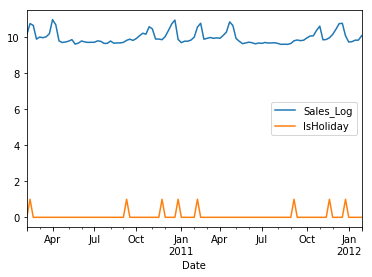

In [93]:
dept_f_train['Sales_Log']=np.log(dept_f_train.Weekly_Sales)
dept_f_train[['Sales_Log','IsHoliday']].plot()

d:\app\Anaconda3\lib\site-packages\pandas\core\internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,Weekly_Sales,IsHoliday,Date,Week_Year
Date,,,,
2010-02-05,24924.50,0,2010-02-05,5
2010-02-12,46039.49,1,2010-02-12,6
2010-02-19,41595.55,0,2010-02-19,7
2010-02-26,19403.54,0,2010-02-26,8
2010-03-05,21827.90,0,2010-03-05,9


In [ ]:
# tmp_1_2=train_data[np.logical_and(train_data.Store==1,train_data.Dept == 2)]
# id_1_2=pd.DataFrame(tmp_1_2['Weekly_Sales'].values,index=pd.DatetimeIndex(tmp_1_2['Date']),columns=['Weekly_Sales'])
# id_1_2.plot(figsize=(20,5))

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# dftest = adfuller(id_1_1.Weekly_Sales.diff().dropna(), autolag='AIC')
# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# for key,value in dftest[4].items():
#     dfoutput['Critical Value (%s)'%key] = value
# dfoutput

In [ ]:
# mod = sm.tsa.statespace.SARIMAX(id_1_1.Weekly_Sales, order=(1,1,1), seasonal_order=(1,1,0,52))
# res = mod.fit()
# res.summary()

In [ ]:
# res.aic,res.bic

In [ ]:
# r,q,p = sm.tsa.acf(res.resid.values.squeeze(), qstat=True)
# data = np.c_[range(1,41), r[1:], q, p]
# table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
# table.set_index('lag')

use lr

In [127]:
full_train=train_data.merge(stores,left_on='Store',right_on='Store').merge(features,left_on=('Store','Date'),right_on=('Store','Date'))
full_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [128]:
full_train[np.logical_and(full_train.Store==1,full_train.Dept==1)].head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
73,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
145,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
218,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
290,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [132]:
full_train['Week_In_Year']=full_train.Date.astype(np.datetime64).apply(lambda d: datetime.date.isocalendar(d)[1])
full_train.head()

d:\app\Anaconda3\lib\site-packages\pandas\core\internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Week_In_Year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5


In [135]:
full_train['IsHoliday']=full_train.IsHoliday_x.astype('int')
full_train.drop(['IsHoliday_x','IsHoliday_y'],axis=1,inplace=True)
full_train.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week_In_Year,IsHoliday
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,0
1,1,2,2010-02-05,50605.27,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,0
2,1,3,2010-02-05,13740.12,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,0
3,1,4,2010-02-05,39954.04,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,0
4,1,5,2010-02-05,32229.38,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,0


In [138]:
depts1=full_train[full_train.Dept==1][['Store','Type','Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','Week_In_Year']]
depts1.head()

,Store,Type,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Week_In_Year
0,1,A,24924.50,151315,42.31,2.572,211.096358,8.106,0,5
73,1,A,46039.49,151315,38.51,2.548,211.242170,8.106,1,6
145,1,A,41595.55,151315,39.93,2.514,211.289143,8.106,0,7
218,1,A,19403.54,151315,46.63,2.561,211.319643,8.106,0,8
290,1,A,21827.90,151315,46.50,2.625,211.350143,8.106,0,9


In [144]:
import sys
sys.path.append('../')
from pipeline import *
from onehot import *
from util import *

full_pipeline=DataFramePipeline([
        FeaturePipeline('Type','',Pipeline([('onehot',LabelBinarizerEx(['Type']))])),
]
)

depts1p=full_pipeline.fit_transform(depts1)
depts1p.head()

,Store,Type,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Week_In_Year,Type_A,Type_B,Type_C
0,1.0,A,24924.5,151315.0,42.31,2.572,211.096358,8.106,0.0,5.0,1.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [ ]:
# test_data = pd.read_csv('raw_data/test.csv')
# test_data.head()

In [ ]:
# result.to_csv('result.csv',header=True,index=False)